In [1]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.sql import text
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import plotly.graph_objects as go
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import sys
from importlib import reload
sys.path.append('../../') 
from credentials import DB_username, DB_password, DB_host, DB_name

In [2]:
# create engine 
for_engine = f'postgresql+psycopg2://{DB_username}:{DB_password}@{DB_host}/{DB_name}'
engine = create_engine(for_engine)

In [3]:
sql = text("SELECT * FROM data.kline_price where category=2 and interval=1 and symbol=1")
kline = pd.read_sql(sql, con=engine).sort_values(by='datetime')
kline['datetime'] = pd.to_datetime(kline['datetime'])
kline.head(1)

,id,datetime,category,interval,symbol,open,high,low,volume,turnover,close,source,created_dt
0,2308471,2020-06-01 16:40:00,2,1,1,9563.5,9565.5,9561.0,7.984,76370.95,9565.5,2,2024-03-12 14:51:28


In [4]:
data = kline[['datetime', 'open', 'high', 'low', 'close']].sort_values(by='datetime')
data

,datetime,open,high,low,close
0,2020-06-01 16:40:00,9563.5,9565.5,9561.0,9565.5
1,2020-06-01 16:41:00,9565.5,9571.0,9565.5,9569.5
2,2020-06-01 16:42:00,9569.5,9573.0,9566.5,9569.5
3,2020-06-01 16:43:00,9569.5,9572.5,9568.0,9571.0
4,2020-06-01 16:44:00,9571.0,9571.0,9568.5,9570.0
...,...,...,...,...,...
2079732,2024-04-17 00:26:00,63646.0,63700.7,63639.5,63675.4
2079731,2024-04-17 00:27:00,63675.4,63675.4,63573.7,63588.6
2079730,2024-04-17 00:28:00,63588.6,63605.0,63560.4,63603.2
2079729,2024-04-17 00:29:00,63603.2,63691.3,63601.6,63691.3


In [79]:
# def for spliting data 
def frame_maker(data, value1, value2, window_data, window_target):
    frame = pd.DataFrame(columns=range(window_data+1))
    for i in tqdm(range(len(data)-window_data-window_target)):
        frame.loc[i, 0:window_data] = data.loc[i:i+window_data][value1].values
        frame.loc[i, 'y_max'] = data.loc[i+window_data:i+window_data+window_target][value1].max()
        frame.loc[i, 'y_delta_max'] = frame.loc[i, 'y_max'] - frame.loc[i, window_data]
    return frame
df = frame_maker(data[1500000:1515000].reset_index(), 'high', 'low', 1000, 100)


100%|██████████| 13900/13900 [1:14:18<00:00,  3.12it/s]


In [80]:
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,993,994,995,996,997,998,999,1000,y_max,y_delta_max
0,27858.4,27865.0,28007.1,27865.5,27870.0,27870.0,27867.0,27870.2,27875.7,27879.8,...,28302.7,28298.6,28302.5,28293.4,28293.4,28302.5,28281.2,28282.0,28409.6,127.6
1,27865.0,28007.1,27865.5,27870.0,27870.0,27867.0,27870.2,27875.7,27879.8,27881.4,...,28298.6,28302.5,28293.4,28293.4,28302.5,28281.2,28282.0,28278.4,28409.6,131.2
2,28007.1,27865.5,27870.0,27870.0,27867.0,27870.2,27875.7,27879.8,27881.4,27882.7,...,28302.5,28293.4,28293.4,28302.5,28281.2,28282.0,28278.4,28279.8,28409.6,129.8


In [81]:
X = df.drop('y_delta_max', axis=1)
y = df['y_delta_max']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [82]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor()
cat.fit(X_train,y_train, verbose=False, plot=True, eval_set=(X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [83]:
predictions = cat.predict(X_test)
print(predictions)


[  959.03937752  1416.84600999    42.52662026 ...  1933.16897652
 10885.62367595   212.21707946]


In [84]:
pred_df = pd.DataFrame({'true':y_test, 'pred':predictions})
pred_df['error']=pred_df['true']-pred_df['pred']

In [85]:
# count MAE df = frame_maker(data[100000:110000].reset_index(), 'high', 1000, 100)
pred_df['error'].abs().mean()

48.30309049654764

In [86]:
pred_df['pred'].abs().mean()

1913.450103648362

In [91]:
pred_df.sample(10)

,true,pred,error
765,268.3,349.958900,-81.658900
9820,16.3,29.507812,-13.207812
8579,47.7,59.953039,-12.253039
6403,9160.2,9180.966440,-20.766440
12670,299.1,307.469642,-8.369642
12826,280.2,113.814564,166.385436
13646,2450.4,2449.372587,1.027413
13644,2392.8,2358.688789,34.111211
8978,14269.7,14125.845753,143.854247
5090,301.8,297.589092,4.210908


<Axes: >

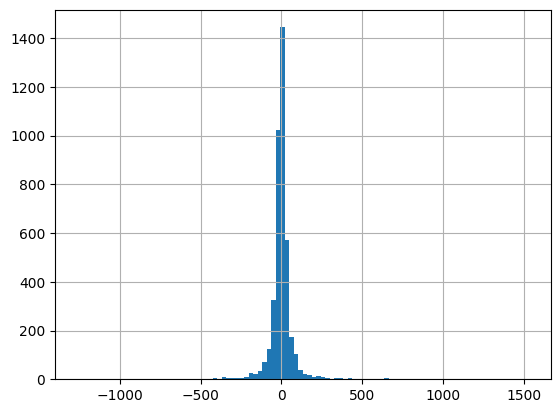

In [87]:
pred_df['error'].hist(bins=100)

In [92]:
data

,datetime,open,high,low,close
0,2020-06-01 16:40:00,9563.5,9565.5,9561.0,9565.5
1,2020-06-01 16:41:00,9565.5,9571.0,9565.5,9569.5
2,2020-06-01 16:42:00,9569.5,9573.0,9566.5,9569.5
3,2020-06-01 16:43:00,9569.5,9572.5,9568.0,9571.0
4,2020-06-01 16:44:00,9571.0,9571.0,9568.5,9570.0
...,...,...,...,...,...
2079732,2024-04-17 00:26:00,63646.0,63700.7,63639.5,63675.4
2079731,2024-04-17 00:27:00,63675.4,63675.4,63573.7,63588.6
2079730,2024-04-17 00:28:00,63588.6,63605.0,63560.4,63603.2
2079729,2024-04-17 00:29:00,63603.2,63691.3,63601.6,63691.3


In [93]:
df

,0,1,2,3,4,5,6,7,8,9,...,993,994,995,996,997,998,999,1000,y_max,y_delta_max
0,27858.4,27865.0,28007.1,27865.5,27870.0,27870.0,27867.0,27870.2,27875.7,27879.8,...,28302.7,28298.6,28302.5,28293.4,28293.4,28302.5,28281.2,28282.0,28409.6,127.6
1,27865.0,28007.1,27865.5,27870.0,27870.0,27867.0,27870.2,27875.7,27879.8,27881.4,...,28298.6,28302.5,28293.4,28293.4,28302.5,28281.2,28282.0,28278.4,28409.6,131.2
2,28007.1,27865.5,27870.0,27870.0,27867.0,27870.2,27875.7,27879.8,27881.4,27882.7,...,28302.5,28293.4,28293.4,28302.5,28281.2,28282.0,28278.4,28279.8,28409.6,129.8
3,27865.5,27870.0,27870.0,27867.0,27870.2,27875.7,27879.8,27881.4,27882.7,27884.0,...,28293.4,28293.4,28302.5,28281.2,28282.0,28278.4,28279.8,28283.3,28409.6,126.3
4,27870.0,27870.0,27867.0,27870.2,27875.7,27879.8,27881.4,27882.7,27884.0,27883.5,...,28293.4,28302.5,28281.2,28282.0,28278.4,28279.8,28283.3,28267.7,28409.6,141.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13895,30324.1,30311.9,30667.8,30545.4,30484.8,30441.1,30406.7,30361.2,30331.7,30297.1,...,29309.1,29296.6,29297.7,29288.8,29280.3,29287.3,29309.1,29309.1,29350.1,41.0
13896,30311.9,30667.8,30545.4,30484.8,30441.1,30406.7,30361.2,30331.7,30297.1,30300.0,...,29296.6,29297.7,29288.8,29280.3,29287.3,29309.1,29309.1,29309.1,29350.1,41.0
13897,30667.8,30545.4,30484.8,30441.1,30406.7,30361.2,30331.7,30297.1,30300.0,30297.0,...,29297.7,29288.8,29280.3,29287.3,29309.1,29309.1,29309.1,29293.7,29350.1,56.4
13898,30545.4,30484.8,30441.1,30406.7,30361.2,30331.7,30297.1,30300.0,30297.0,30314.5,...,29288.8,29280.3,29287.3,29309.1,29309.1,29309.1,29293.7,29309.1,29350.1,41.0


In [94]:
28267.7 - 28409.6

-141.89999999999782